# ML Project 2 - Neural nets

In [83]:
import os
import scipy.stats
import sklearn.metrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

# For neural net part
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

In [3]:
import pickle
import k_models

## Table of content
0. [Import data](#import)
1. [Data preprocessing](#preprocess) <br>
    1.1 [Load *n* data](#load_n_data) <br>
    1.2 [Remove outliers](#outliers) <br>
    1.3 [Standardize data](#std) <br>
    1.4 [PCA](#pca) <br>
2. [PyTorch NN](#pytorch) <br>
    2.1 [Functions](#p_functions) <br>
    2.2 [Architecture 1](#p_architecture1) <br>
    2.3 [Architecture 2](#p_architecture2) <br>
    2.4 [Architecture 3](#p_architecture3) <br>
3. [Keras NN](#keras) <br>
    3.1 [Architecture 1](#k_architecture1) <br>
    3.2 [Architecture 2](#k_architecture2) <br>
4. [Main](#main) <br>
    4.1 [PyTorch pipeline](#main_pytorch) <br>
    4.2 [Keras pipeline](#main_keras) <br>
5. [Statistics](#stats) <br>
    5.1 [IQR vs *n*](#iqr_vs_n) <br>
6. [Figures](#figures) <br>
    6.1 [Distributions](#fig_dist) <br>
    6.2 [IQR](#fig_iqr) <br>
    6.3 [Feature distributions](#fig_feature_dist) <br>

## 0. Import data
<a id='import'></a>

In [96]:
data_folder = './data'

files = os.listdir(data_folder)  
X_files = [filename for filename in files if (filename.endswith('.npy') and ('rsr' in filename))]
y_files = [filename for filename in files if (filename.endswith('.npy') and ('chemical_shielding' in filename))]


X_tot = np.load(data_folder + '/' + X_files[1], mmap_mode='r')
y_tot = np.load(data_folder + '/' + y_files[0], mmap_mode='r')

In [97]:
print(X_tot.shape)
print(y_tot.shape)

(38514, 14400)
(38514,)


## 1. Data preprocessing
<a id='preprocess'></a>

In [ ]:
import data_preprocessing

#### 1.1 Load *n* data
<a id='load_n_data'></a>

In [98]:
def load_data(n_samples, tot_data_x=X_tot, tot_data_y=y_tot, iqr=False):
    if iqr:
        tot_data_x, tot_data_y = remove_outliers(tot_data_x, tot_data_y)
    
    data_len = tot_data_x.shape[0]
    mask_data = np.random.permutation(data_len)[:n_samples]

    data_X = tot_data_x[mask_data]
    data_y = tot_data_y[mask_data]
    return data_X, data_y

In [99]:
def load_data_train_test(n_samples, tot_data_x=X_tot, tot_data_y=y_tot, iqr=False):
    data_X, data_y = load_data(n_samples, tot_data_x, tot_data_y, iqr=iqr)
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size = 0.2)
    return X_train, X_test, y_train, y_test

#### 1.2 Remove outliers
<a id='outliers'></a>

*c.f.* `data_preprocessing.py`

In [8]:
def remove_outliers(X_data, y_data):
    ''' aims at removing all rows whose label (i.e. shielding) is considered as outlier.
    output:
     - X_filtered
     - y_filtered
    '''
    q1, q3 = np.percentile(y_data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    assert(q1 != q3), 'Q1 and Q3 have the same value'
    
    idx = np.where((y_data > lower_bound) & (y_data < upper_bound))
    X_filtered = X_data[idx]
    y_filtered = y_data[idx]
    
    assert(X_filtered.shape[0] == y_filtered.shape[0]), 'Problem'
    
    # alternative
    #dists[(np.where((dists >= r) & (dists <= r + dr)))]
    
    return X_filtered, y_filtered

In [116]:
def plot_distributions(data):
    fig, ax = plt.subplots(figsize=(6,7))
    plt.subplot(2,1,1)
    plt.title('Distribution of the shielding')
    sns.distplot(data).set(xlim=(-5,65),ylim=(0,0.14))
    plt.subplot(2,1,2)
    sns.boxplot(x=data, linewidth=1.5).set(xlabel='Shielding', xlim=(-5,65))

In [125]:
#plot_distributions(y_tot)

In [88]:
X_filtered, y_filtered = remove_outliers(X_tot, y_tot)

In [126]:
#plot_distributions(y_filtered)

In [93]:
print('There are {} outliers'.format(y_tot.shape[0] - y_filtered.shape[0]))

There are 1176 outliers


#### 1.3 Standardize data
<a id='std'></a>

*c.f.* `data_preprocessing.py`

In [104]:
def apply_scaler(scaler, X_train, X_test):
    """
    Function to scale outside of the pipeline.
    """
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

#### 1.4 PCA
<a id='pca'></a>

In [120]:
def plot_PCA(n_comp, X_train):
    """
    displays the 'elbow' of the PCA, ie the screeplot"""
    pca = PCA(n_components = n_comp)
    pca.fit(X_train)
    plt.figure(1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.show()

In [9]:
def do_PCA(X_train, X_test, n):
    """
    Useful method to reduce train/test sets outside of the pipeline
    """
    pca = PCA(n_components=n)
    # Note on fit_transform: internally, it just calls first fit() and then transform() on the same data.
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return X_train, X_test

## 2. PyTorch NN
<a id='pytorch'></a>

#### 2.1 Functions
<a id='p_functions'></a>

In [46]:
def train_model(model, train_input, train_target, mini_batch_size, monitor_loss=False):
    '''Train the model using Mini-batch SGD'''
    
    criterion = nn.MSELoss() #regression task
    optimizer = optim.Adam(model.parameters(), lr = 1e-4) #1e-4 normalement
    nb_epochs = 150
    
    # Monitor loss
    losses = []
    
    for e in range(nb_epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            
            sum_loss += loss.item() #compute loss for each mini batch for 1 epoch
            
            optimizer.step()
        
        # Monitor loss
        losses.append(sum_loss)
        
        print('[epoch {:d}] loss: {:0.2f}'.format(e+1, sum_loss))
    
    if monitor_loss:
        return losses

In [11]:
def compute_pred(model, data_input):
    '''Given a trained model, output the prediction corresponding to data_input'''
    y_hat = model(data_input)
    return y_hat

In [24]:
def compute_score(y_actual, y_pred):
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    #print("Obtained MSE on test set %2.2f " % mse)
    #print("Obtained MAE on test set %2.2f " % mae)
    return mse, mae, r2

#### 2.2 Architecture 1
<a id='p_architecture1'></a>

In [127]:
class Net(nn.Module):
    def __init__(self, n):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n,100)
        self.fc2 = nn.Linear(100,1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

#### 2.3 Architecture 2
<a id='p_architecture2'></a>

In [238]:
# Simply add dropout layers
Net_2 = nn.Sequential(nn.Linear(14400, 100), nn.ReLU(),
                      #nn.Dropout(),
                      nn.Linear(100, 50), nn.ReLU(),
                      nn.Dropout(p=.2),
                      nn.Linear(50, 1));

In [128]:
# TODO: test this one with dropout
class Net_2(nn.Module):
    def __init__(self, n):
        super(Net_2, self).__init__()
        self.fc1 = nn.Linear(n,100)
        self.fc2 = nn.Linear(100,1)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x

#### 2.4 Architecture 3
<a id='p_architecture3'></a>

In [91]:
class Net_3(nn.Module):
    def __init__(self, n):
        super(Net_3, self).__init__()
        self.fc1 = nn.Linear(n,100)
        self.fc2 = nn.Linear(100,1)
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

In [144]:
class Net_4(nn.Module):
    def __init__(self, n):
        super(Net_4, self).__init__()
        self.fc1 = nn.Linear(n,100)
        self.fc2 = nn.Linear(100,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        return x

In [140]:
class Net_5(nn.Module):
    def __init__(self, n):
        super(Net_5, self).__init__()
        self.fc1 = nn.Linear(n,100)
        self.fc2 = nn.Linear(100,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,50)
        self.fc5 = nn.Linear(50,1)
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        return x

## 3. Keras NN
<a id='keras'></a>

#### 3.1 Architecture 1
<a id='k_architecture1'></a>

In [155]:
def keras_model_2(input_data, metric):
    '''return a model based on the input_data size (i.e. nb of features)
       metric: 'mean_absolute_error' OR 'mean_square_error'
    '''
    # instantiate 
    model = Sequential()

    # input Layer
    model.add(Dense(50, kernel_initializer='normal',input_dim = input_data.shape[1], activation='relu')) # test with 50 or 100 here

    # output Layer
    model.add(Dense(1, kernel_initializer='normal',activation='relu')) # change last activation 'linear', 'sigmoid'

    # compile the network
    model.compile(loss=metric, optimizer='adam', metrics=[metric])

    return model

#### 3.2 Architecture 2
<a id='k_architecture2'></a>

_c.f._ `k_models.py` file.

## 4. Main
<a id='main'></a>

In [ ]:
# Load data prior feeding it to the mode
def load_process_data(n, iqr=False, pca=False, scale=False):
    # load all datas
    # filter (iqr)
    if iqr:
        # remove outliers
    # select n samples and split in train-test sets
    # perform pca
    if pca:
        # do pca
    # normalize 
    if scale:
        # do normalization
    #return X_train, X_test, y_train, y_test
    raise NotImplementedError 

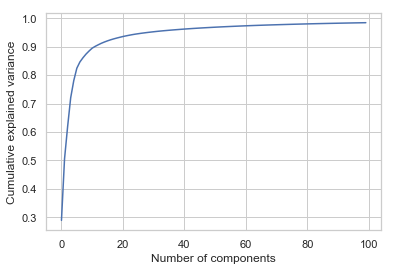

In [123]:
# How man PCA components do we need?
plot_PCA(100, X_filtered)

>40 components to explain 95% of the total variance.

#### 4.1 PyTorch pipeline
<a id='main_pytorch'></a>

In [130]:
apply_iqr = True
apply_scaler_ = False
apply_pca = False

nb_input_neurons = 14400

if apply_iqr:
    X_train, X_test, y_train, y_test = load_data_train_test(12000, X_tot, y_tot, iqr=apply_iqr)
else:
    X_train, X_test, y_train, y_test = load_data_train_test(12000, X_tot, y_tot) #38514

if apply_scaler_:
    min_max = MinMaxScaler()
    X_train, X_test = apply_scaler(min_max, X_train, X_test)
    
if apply_pca:
    n = 80
    X_train, X_test = do_PCA(X_train, X_test, n)
    nb_input_neurons = n

train_input = torch.Tensor(X_train)
test_input = torch.Tensor(X_test)
train_target = torch.Tensor(y_train.reshape(len(y_train), 1))
test_target = torch.Tensor(y_test.reshape(len(y_test), 1))

In [141]:
mini_batch_size = 10
model = Net_5(nb_input_neurons) 
losses = train_model(model, train_input, train_target, mini_batch_size, monitor_loss=True)

[epoch 1] loss: 176932.25
[epoch 2] loss: 3867.05
[epoch 3] loss: 2556.41
[epoch 4] loss: 1799.85
[epoch 5] loss: 1359.80
[epoch 6] loss: 1122.91
[epoch 7] loss: 981.16
[epoch 8] loss: 888.16
[epoch 9] loss: 821.82
[epoch 10] loss: 771.12
[epoch 11] loss: 730.33
[epoch 12] loss: 696.36
[epoch 13] loss: 667.45
[epoch 14] loss: 642.32
[epoch 15] loss: 620.05
[epoch 16] loss: 600.56
[epoch 17] loss: 583.12
[epoch 18] loss: 567.44
[epoch 19] loss: 553.22
[epoch 20] loss: 540.16
[epoch 21] loss: 528.07
[epoch 22] loss: 516.26
[epoch 23] loss: 505.37
[epoch 24] loss: 495.33
[epoch 25] loss: 485.95
[epoch 26] loss: 477.12
[epoch 27] loss: 468.63
[epoch 28] loss: 460.65
[epoch 29] loss: 452.96
[epoch 30] loss: 445.87
[epoch 31] loss: 439.09
[epoch 32] loss: 432.60
[epoch 33] loss: 426.42
[epoch 34] loss: 420.48
[epoch 35] loss: 414.70
[epoch 36] loss: 409.24
[epoch 37] loss: 404.05
[epoch 38] loss: 399.00
[epoch 39] loss: 394.11
[epoch 40] loss: 389.35
[epoch 41] loss: 384.88
[epoch 42] loss: 

In [142]:
#model.train(False)

#Make predictions
y_hat = compute_pred(model, test_input)

#Compute score
mse_nn, mae_nn, r2_nn = compute_score(y_test, y_hat.detach().numpy())

print('MSE: {:0.2f} \nMAE: {:0.2f} \nr2: {:0.2f}'.format(mse_nn, mae_nn, r2_nn))

MSE: 0.54 
MAE: 0.54 
r2: 0.94


In [ ]:
with open('y_hat_all_dataset2_net3.pkl', 'wb') as f:
    pickle.dump(y_hat, f)

##### 4-fold cross-validation

In [143]:
from sklearn.model_selection import KFold

mse_storage = []
mae_storage = []
r2_storage = []

mini_batch_size = 10
nb_input_neurons = 14400

# Load data, remove outliers but do not split yet into train and test
X, y = load_data(38514, tot_data_x=X_tot, tot_data_y=y_tot, iqr=True)

print(X.shape)
print(y.shape)

(37338, 14400)
(37338,)


In [145]:
X[:-338].shape

(37000, 14400)

In [146]:
X = X[:-338]
y = y[:-338]

In [ ]:
kf = KFold(n_splits=4, shuffle=True)

for idx, (train_index, test_index) in enumerate(kf.split(X)):
    print("FOLD {}".format(idx+1))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_input = torch.Tensor(X_train)
    test_input = torch.Tensor(X_test)
    train_target = torch.Tensor(y_train.reshape(len(y_train), 1))
    test_target = torch.Tensor(y_test.reshape(len(y_test), 1))
    
    model = Net_4(nb_input_neurons) 
    losses = train_model(model, train_input, train_target, mini_batch_size, monitor_loss=True)

    #Make predictions
    y_hat = compute_pred(model, test_input)
    #Compute score
    mse_nn, mae_nn, r2_nn = compute_score(y_test, y_hat.detach().numpy())
    
    mse_storage.append(mse_nn)
    mae_storage.append(mae_nn)
    r2_storage.append(r2_nn)

FOLD 1
[epoch 1] loss: 195956.91
[epoch 2] loss: 5717.32


In [51]:
with open('metrics_all_dataset2_net4_4fold.pkl', 'wb') as f:
    pickle.dump([mse_storage, mae_storage, r2_storage], f)

In [53]:
print('MSE: {:0.2f} +/- {:0.4f} \nMAE: {:0.2f} +/- {:0.4f} \nR2: {:0.2f} +/- {:0.4f}'.format(np.mean(mse_storage), np.std(mse_storage), np.mean(mae_storage), np.std(mae_storage), np.mean(r2_storage), np.std(r2_storage)))

MSE: 0.42 +/- 0.0069 
MAE: 0.48 +/- 0.0047 
R2: 0.95 +/- 0.0008


#### 4.2 Keras pipeline
<a id='main_keras'></a>

In [15]:
models = [k_models.model_5, k_models.model_6, k_models.model_7]

model_names = [] #[m.__name__ for m in models]
epochs_list = []
mse_list = []
mae_list = []

X_train, X_test, y_train, y_test = load_data_train_test(2000, X_tot, y_tot)

nb_epochs = [100]
for m in models:
    for e in nb_epochs:
        network = m(X_train, 'mean_absolute_error')
        network.fit(X_train, y_train, epochs=e, batch_size=10, validation_split=0.2)

        y_hat = network.predict(X_test)
        mse_nn, mae_nn = compute_score(y_test, y_hat)

        model_names.append(m.__name__)
        epochs_list.append(e)
        mse_list.append(mse_nn)
        mae_list.append(mae_nn)


Train on 1280 samples, validate on 320 samples
Epoch 1/100
1280/1280 [==============================] - 2s 2ms/step - loss: 20.5533 - mean_absolute_error: 20.5534 - val_loss: 10.6779 - val_mean_absolute_error: 10.6779
Epoch 2/100
1280/1280 [==============================] - 2s 2ms/step - loss: 3.4412 - mean_absolute_error: 3.4412 - val_loss: 2.1116 - val_mean_absolute_error: 2.1116
Epoch 3/100
1280/1280 [==============================] - 2s 2ms/step - loss: 1.8856 - mean_absolute_error: 1.8856 - val_loss: 1.7832 - val_mean_absolute_error: 1.7832
Epoch 4/100
1280/1280 [==============================] - 2s 2ms/step - loss: 1.6338 - mean_absolute_error: 1.6338 - val_loss: 1.6364 - val_mean_absolute_error: 1.6364
Epoch 5/100
1280/1280 [==============================] - 2s 2ms/step - loss: 1.4684 - mean_absolute_error: 1.4684 - val_loss: 1.4507 - val_mean_absolute_error: 1.4507
Epoch 6/100
1280/1280 [==============================] - 2s 2ms/step - loss: 1.3487 - mean_absolute_error: 1.3487 

In [16]:
print(tabulate([model_names, ['Epochs']+epochs_list, ['MSE']+mse_list, ['MAE']+mae_list], headers="firstrow", tablefmt='fancy_grid'))

╒════════╤════════════╤════════════╤════════════╕
│        │    model_5 │    model_6 │    model_7 │
╞════════╪════════════╪════════════╪════════════╡
│ Epochs │ 100        │ 100        │ 100        │
├────────┼────────────┼────────────┼────────────┤
│ MSE    │   1.01402  │   0.944624 │   1.2443   │
├────────┼────────────┼────────────┼────────────┤
│ MAE    │   0.768377 │   0.754768 │   0.866663 │
╘════════╧════════════╧════════════╧════════════╛


In [291]:
# Quick tests
apply_pca = False
apply_iqr = True

if apply_iqr:
    X_train, X_test, y_train, y_test = load_data_train_test(12000, X_tot, y_tot, iqr=apply_iqr)
else:
    X_train, X_test, y_train, y_test = load_data_train_test(12000, X_tot, y_tot)

if apply_pca:
    n = 100
    X_train, X_test = do_PCA(X_train, X_test, n)
    nb_input_neurons = n


In [338]:
k_ann = k_models.model_8(X_train, 'mean_absolute_error') 
k_ann.fit(X_train, y_train, epochs=150, batch_size=10, validation_split=0.2)

Train on 7680 samples, validate on 1920 samples
Epoch 1/150
7680/7680 [==============================] - 27s 3ms/step - loss: 4.3517 - val_loss: 1.1326
Epoch 2/150
7680/7680 [==============================] - 23s 3ms/step - loss: 1.0146 - val_loss: 0.8708
Epoch 3/150
7680/7680 [==============================] - 23s 3ms/step - loss: 0.8197 - val_loss: 0.7872
Epoch 4/150
7680/7680 [==============================] - 21s 3ms/step - loss: 0.7380 - val_loss: 0.7370
Epoch 5/150
7680/7680 [==============================] - 22s 3ms/step - loss: 0.6953 - val_loss: 0.6850
Epoch 6/150
7680/7680 [==============================] - 28s 4ms/step - loss: 0.6662 - val_loss: 0.6687
Epoch 7/150
7680/7680 [==============================] - 23s 3ms/step - loss: 0.6464 - val_loss: 0.6513
Epoch 8/150
7680/7680 [==============================] - 22s 3ms/step - loss: 0.6306 - val_loss: 0.6370
Epoch 9/150
7680/7680 [==============================] - 22s 3ms/step - loss: 0.6140 - val_loss: 0.6369
Epoch 10/150
768

In [339]:
# test model
y_hat = k_ann.predict(X_test)

# compute score
mse_nn, mae_nn, _ = compute_score(y_test, y_hat)
print('MSE: {:.2f} \nMAE: {:.2f}'.format(mse_nn, mae_nn))

MSE: 0.58 
MAE: 0.57


In [340]:
with open('y_hat_12000_dataset2_model8.pkl', 'wb') as f:
    pickle.dump(y_hat, f)

**Results tracking**

Model    | MSE  | MAE  | PCA | IQR |    n     | dataset | *n* PCs | Epochs | Scaling | 
---      | ---  | ---  | --- | --- |   ---    |   ---   |   ---   |   ---  |   ---   |
model_6  | 0.93 | 0.70 | Yes | Yes |  20000   |   2     |   40    |   150  |   No    |
model_6  | 0.85 | 0.67 | No  | Yes |   4000   |   2     |    -    |   150  |   No    |
model_6  | 0.78 | 0.64 | Yes | Yes |  20000   |   2     |   60    |   150  |   No    | 
model_6  | 0.75 | 0.63 | Yes | Yes |  25000   |   2     |   70    |   200  |   No    |
model_6  | 0.67 | 0.60 | No  | Yes |   8000   |   2     |    -    |   150  |   No    |
model_6  | 0.75 | 0.62 | Yes | Yes |  25000   |   2     |  100    |   150  |   No    |
model_6  | 0.60 | 0.55 | No  | Yes |  12000   |   2     |    -    |   150  |   No    |
Net_3    | 1.01 | 0.74 | Yes | Yes |   5000   |   2     |   80    |   100  |   No    |
Net_3    | 1.03 | 0.73 | Yes | Yes |   8000   |   2     |   80    |   150  |   No    |
Net_3    | 0.65 | 0.60 | No  | Yes |   8000   |   2     |    -    |   150  |   No    |
Net_3    | 0.52 | 0.54 | No  | Yes |  12000   |   2     |    -    |   150  |   No    |
model_8  | 0.58 | 0.57 | No  | Yes |  12000   |   2     |    -    |   150  |   No    |
Net_3    | 0.57 | 0.56 | No  | Yes |  12000   |   3     |    -    |   150  |   No    |
Net_3    | 0.65 | 0.62 | No  | Yes |  12000   |   2     |    -    |   150  |   Yes   |
Net_3    | 1.00 | 0.76 | Yes | Yes |  12000   |   2     |   80    |   150  |   Yes   |
Net_3    | 0.86 | 0.69 | Yes | Yes |  25000   |   2     |   80    |   150  |   Yes   |
Net_4    | 0.47 | 0.52 | No  | Yes |  12000   |   2     |   -     |   150  |   Yes   |
Net_5    | 0.54 | 0.54 | No  | Yes |  12000   |   2     |   -     |   150  |   Yes   |

Note: 
- Larger increase in performances when using more PCs (say 60).
- Obviously computationally less demanding
- Will the increase in number of samples without PCA perform better? YES it does.
- Loss evolution indicates that 150 epochs are not necessary (try with 120)
- Plateau reached using larger number of PCs
- $r^2 = 0.95$ for Net_4

## 5. Stats
<a id='stats'></a>

#### 5.1 IQR vs. sample number
<a id='iqr_vs_n'></a>

Note: I should do a function but j'ai la flemme.

In [19]:
# To save time: always apply PCA for now
apply_pca = True
apply_iqr = [False, True]
n_samples = [5000, 20000] #[5000, 20000]
n_iter = 4 #5

noiqr_5000 = []
noiqr_20000 = []
iqr_5000 = []
iqr_20000 = []

for b in apply_iqr:
    for n in n_samples:
        for i in range(n_iter):
            # load each time a different set (kind of cross-val)
            X_train, X_test, y_train, y_test = load_data_train_test(n, X_tot, y_tot, iqr=b)
            
            # PCA
            if apply_pca:
                n_pcs = 80
                X_train, X_test = do_PCA(X_train, X_test, n_pcs)
                #nb_input_neurons = n
            
            # NN
            k_ann = k_models.model_6(X_train, 'mean_absolute_error') 
            k_ann.fit(X_train, y_train, epochs=150, batch_size=10, validation_split=0.2)
            
            y_hat = k_ann.predict(X_test)
            mse_nn, mae_nn = compute_score(y_test, y_hat)
            
            # Store result
            # Case: iqr, 5000 samples
            if (b and (n == n_samples[0])):
                iqr_5000.append(mse_nn)
            elif ((not b) and (n == n_samples[0])):
                noiqr_5000.append(mse_nn)
            elif (b and (n == n_samples[1])):
                iqr_20000.append(mse_nn)
            else:
                noiqr_20000.append(mse_nn)

Train on 3200 samples, validate on 800 samples
Epoch 1/150
3200/3200 [==============================] - 1s 287us/step - loss: 20.0163 - val_loss: 7.9898
Epoch 2/150
3200/3200 [==============================] - 1s 174us/step - loss: 2.1726 - val_loss: 1.1877
Epoch 3/150
3200/3200 [==============================] - 1s 176us/step - loss: 1.0646 - val_loss: 0.9910
Epoch 4/150
3200/3200 [==============================] - 1s 176us/step - loss: 0.9258 - val_loss: 0.8876
Epoch 5/150
3200/3200 [==============================] - 1s 174us/step - loss: 0.8713 - val_loss: 0.8659
Epoch 6/150
3200/3200 [==============================] - 1s 172us/step - loss: 0.8536 - val_loss: 0.8499
Epoch 7/150
3200/3200 [==============================] - 1s 175us/step - loss: 0.8411 - val_loss: 0.8589
Epoch 8/150
3200/3200 [==============================] - 1s 173us/step - loss: 0.8331 - val_loss: 0.8565
Epoch 9/150
3200/3200 [==============================] - 1s 176us/step - loss: 0.8326 - val_loss: 0.8517
Epoch 1

In [20]:
with open('stats_iqr_vs_n_2.pkl', 'wb') as f:
    pickle.dump([noiqr_5000, noiqr_20000, iqr_5000, iqr_20000], f)

## 6. Figures
<a id='figures'></a>

#### 6.1 Distributions
<a id='fig_dist'></a>

[(-5, 65), Text(0.5, 0, 'Shielding')]

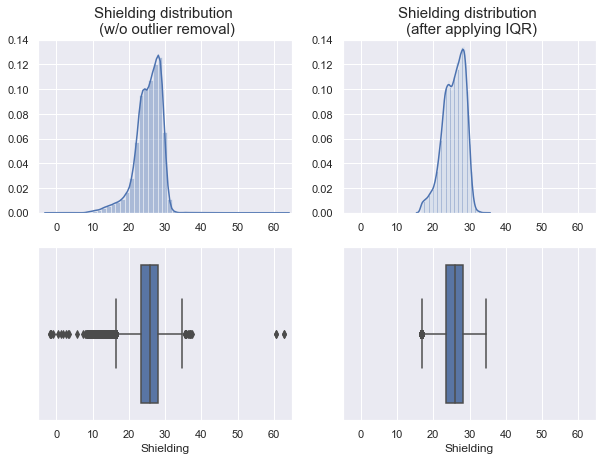

In [222]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1) 
plt.subplot(2,2,1)
plt.title('Shielding distribution \n (w/o outlier removal)', fontsize=15)
sns.distplot(y_tot).set(xlim=(-5,65),ylim=(0,0.14))
plt.subplot(2,2,2)
plt.title('Shielding distribution \n (after applying IQR)', fontsize=15)
sns.distplot(y_filtered).set(xlim=(-5,65),ylim=(0,0.14))
plt.subplot(2,2,3)
b1 = sns.boxplot(x=y_tot, linewidth=1.5).set(xlabel='Shielding', xlim=(-5,65))
#b1.set_xlabel("Shielding",fontsize=10)
plt.subplot(2,2,4)
sns.boxplot(x=y_filtered, linewidth=1.5).set(xlabel='Shielding', xlim=(-5,65))

In [223]:
fig.savefig("iqr.png")

#### 6.2 IQR
<a id='fig_iqr'></a>

In [21]:
df_iqr = pd.DataFrame({
    'noiqr_5000': noiqr_5000,
    'noiqr_20000': noiqr_20000,
    'iqr_5000': iqr_5000,
    'iqr_20000': iqr_20000
})
df_iqr

,noiqr_5000,noiqr_20000,iqr_5000,iqr_20000
0,1.966410,1.164088,0.891626,0.832680
1,1.286497,1.257255,0.887988,0.744232
2,1.757331,0.852787,1.002124,0.833200
3,1.238798,1.663109,1.009964,0.722377


In [63]:
tot_iqr_n = noiqr_5000 + noiqr_20000 + iqr_5000 + iqr_20000

iqrs_labels = ['no','no','no','no','no','no','no','no','yes','yes','yes','yes','yes','yes','yes','yes']
n_labels = [5000,5000,5000,5000,20000,20000,20000,20000,5000,5000,5000,5000,20000,20000,20000,20000]

my_df = pd.DataFrame({
    'mse': tot_iqr_n,
    'iqr': iqrs_labels,
    'n': n_labels
})
my_df

,mse,iqr,n
0,1.966410,no,5000
1,1.286497,no,5000
2,1.757331,no,5000
3,1.238798,no,5000
4,1.164088,no,20000
5,1.257255,no,20000
6,0.852787,no,20000
7,1.663109,no,20000
8,0.891626,yes,5000
9,0.887988,yes,5000


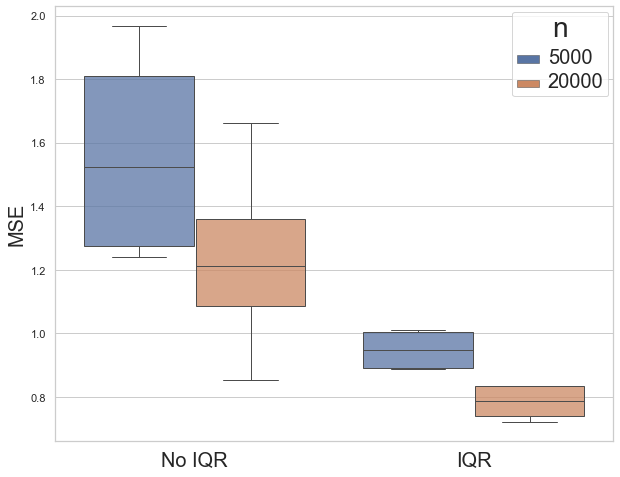

In [86]:
iqr_vs_n, _ = plt.subplots(figsize=(10,8))
sns.set(style="whitegrid")

ax = sns.boxplot(data=my_df, x='iqr', y='mse', hue='n', linewidth=1.)
ax.set_xticklabels(['No IQR', 'IQR'], fontsize=20)
ax.set_xlabel('', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)

plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='28')

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .75))

In [82]:
iqr_vs_n.savefig("iqr_vs_n_2.png")

#### 6.3 Feature distributions
<a id='fig_feature_dist'></a>

In [ ]:
feature_number = [12711, 1457, 4502]

feature_0 = X_tot[:, feature_number[0]]
feature_1 = X_tot[:, feature_number[1]]
feature_2 = X_tot[:, feature_number[2]]


fig = plt.figure(figsize=(14,5))

# Divide the figure into a 2x1 grid, and give me the first section
ax_1 = fig.add_subplot(131)

# Divide the figure into a 2x1 grid, and give me the second section
ax_2 = fig.add_subplot(132)
ax_3 = fig.add_subplot(133)


sns.distplot(feature_0, ax=ax_1, kde=False, hist_kws=dict(edgecolor="w", linewidth=1))

ax_1.axes.set_title("Feature {}".format(str(feature_number[0]), fontsize=20))
ax_1.set_xlabel("", fontsize=17)
ax_1.set_ylabel("Count",fontsize=17)

sns.distplot(feature_1, ax=ax_2, kde=False, hist_kws=dict(edgecolor="w", linewidth=1))

ax_2.axes.set_title("Feature {}".format(str(feature_number[1]), fontsize=20))
ax_2.set_xlabel("Feature value", fontsize=17)
ax_2.set_ylabel("", fontsize=17)
                    
sns.distplot(feature_2, ax=ax_3, kde=False, hist_kws=dict(edgecolor="w", linewidth=1))

ax_3.axes.set_title("Feature {}".format(str(feature_number[2]), fontsize=20))
ax_3.set_xlabel("", fontsize=17)
ax_3.set_ylabel("", fontsize=17)

fig.subplots_adjust(hspace=0.3)

>Note NN
- Simple model is the best (1 hidden of 100 neurons)
- For now dropout does not help
- Increasing the number of hidden neurons to 200 does not help
- Decreasing the number of hidden neurons to 50 shows problem of cenvergence
- Increasing the number of samples show little or no improvements (filter with **IQR** and **minmaxscaler** before and/or **PCA**)
- Test Dropout in PyTorch (specify when training and when NOT training)!
- Again even with batch norm, the simplest model with one hidden seems the best
- Keras: Adam better for model 3 with 100 neurons in hidden layer (sinon does not converge with SGD). Can also try with opt='adam' (...)
- **OK definitely best with 100 hidden neurons and adam as optimizer**
- Now check with PCA, min_max scaling
- Increasing the number of epochs seems a good idea
- IQR helps (ouf)!
- Increasing the number of samples helps also (ouf)!
- Not sure if PCA useful with Keras models
- Model_6 still the best at this point. Try with DEEP net (lots of 'small' layers)?

> About PCA
- Shall we normalize before?
- How does the PCA method from sklearn work? Normalize before?
- When trying without PCA > apply a SCALER